In [1]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import matplotlib.image as mpimg

In [2]:
client = bigquery.Client(project='subugoe-collaborative')

In [3]:
openalex_snapshot = 'subugoe-collaborative.openalex.works'
walden_snapshot = 'subugoe-collaborative.openalex_walden.works'

In [4]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=9) 
plt.rc('axes', titlesize=9) 
plt.rc('axes', labelsize=9) 
plt.rc('xtick', labelsize=9) 
plt.rc('ytick', labelsize=9) 
plt.rc('legend', fontsize=9)

In [5]:
def calculate_changes(df1_openalex, df2_walden, on):
    changes = pd.merge(df1_openalex, df2_walden, on=on, how='outer', suffixes=('_openalex', '_walden'))

    changes['n_openalex'] = changes['n_openalex'].fillna(0)
    changes['n_walden'] = changes['n_walden'].fillna(0)
    changes = changes[[on, 'n_openalex', 'n_walden']]

    changes['change'] = changes['n_walden'] - changes['n_openalex']
    changes['pct_change'] = (changes['n_walden'] - changes['n_openalex']) / changes['n_openalex'] * 100
    #changes['pct_change'] = changes['pct_change'].apply(lambda x: '{:,.2f}'.format(x))

    return changes

In [6]:
oal_by_types = client.query(f"""
                             SELECT COUNT(DISTINCT(doi)) AS n, type
                             FROM `subugoe-collaborative.openalex.works`
                             WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2018 AND 2024
                             GROUP BY type
                             ORDER BY n DESC
                             """).to_dataframe()

In [7]:
walden_by_types = client.query(f"""
                                SELECT COUNT(DISTINCT(doi)) AS n, type
                                FROM {walden_snapshot}
                                WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2018 AND 2024
                                GROUP BY type
                                ORDER BY n DESC
                                """).to_dataframe()

In [8]:
types_plot = calculate_changes(oal_by_types, walden_by_types, on='type')

In [9]:
types_plot['n_openalex_total'] = types_plot['n_openalex'].sum()
types_plot['openalex_share'] = types_plot['n_openalex'] / types_plot['n_openalex_total'] * 100

types_plot['n_walden_total'] = types_plot['n_walden'].sum()
types_plot['walden_share'] = types_plot['n_walden'] / types_plot['n_walden_total'] * 100

In [10]:
types_plot

,type,n_openalex,n_walden,change,pct_change,n_openalex_total,openalex_share,n_walden_total,walden_share
0,article,33440278,33461175,20897,0.062491,37162947,89.982848,37265660,89.790909
1,review,1443989,1432537,-11452,-0.793081,37162947,3.885561,37265660,3.844121
2,paratext,930439,939242,8803,0.946113,37162947,2.503674,37265660,2.520395
3,letter,424062,419502,-4560,-1.075314,37162947,1.141088,37265660,1.125707
4,reference-entry,223020,219102,-3918,-1.756793,37162947,0.600114,37265660,0.587946
5,editorial,216188,214769,-1419,-0.656373,37162947,0.58173,37265660,0.576319
6,erratum,151724,150723,-1001,-0.659751,37162947,0.408267,37265660,0.404455
7,other,96666,94824,-1842,-1.90553,37162947,0.260114,37265660,0.254454
8,book-chapter,86699,171301,84602,97.581287,37162947,0.233294,37265660,0.459675
9,dataset,79573,3474,-76099,-95.634198,37162947,0.214119,37265660,0.009322


In [11]:
types_plot.replace(to_replace='preprint', value='preprint*', inplace=True)
types_plot.replace(to_replace='dissertation', value='dissertation*', inplace=True)

In [13]:
print(types_plot[['type', 'n_openalex', 'n_walden', 'change', 'pct_change', 'openalex_share', 'walden_share']].to_markdown())

|    | type                    |   n_openalex |   n_walden |   change |   pct_change |   openalex_share |   walden_share |
|---:|:------------------------|-------------:|-----------:|---------:|-------------:|-----------------:|---------------:|
|  0 | article                 |     33440278 |   33461175 |    20897 |    0.0624905 |     89.9828      |   89.7909      |
|  1 | review                  |      1443989 |    1432537 |   -11452 |   -0.793081  |      3.88556     |    3.84412     |
|  2 | paratext                |       930439 |     939242 |     8803 |    0.946113  |      2.50367     |    2.5204      |
|  3 | letter                  |       424062 |     419502 |    -4560 |   -1.07531   |      1.14109     |    1.12571     |
|  4 | reference-entry         |       223020 |     219102 |    -3918 |   -1.75679   |      0.600114    |    0.587946    |
|  5 | editorial               |       216188 |     214769 |    -1419 |   -0.656373  |      0.58173     |    0.576319    |
|  6 | erratum  

In [32]:
change_color = ['#c3c3c3' if (x < 0) else '#fc5185' for x in types_plot.change]

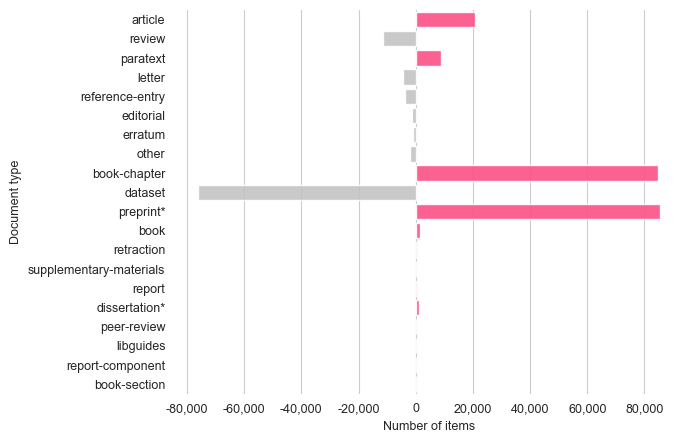

In [89]:
fig, ax = plt.subplots(figsize=(7,4.5))
plt.box(False)

sns.barplot(data=types_plot, 
            x='change', 
            y='type', 
            orient='h',
            saturation=1,
            palette=change_color,
            hue='type',
            alpha=0.9,
            zorder=3,
            errorbar=None,)

ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

ax.set(xlabel='Number of items', ylabel='Document type')

plt.tight_layout()

plt.show()
fig.savefig('media/blog_post_document_types_changes.png', format='png', bbox_inches='tight', dpi=500)

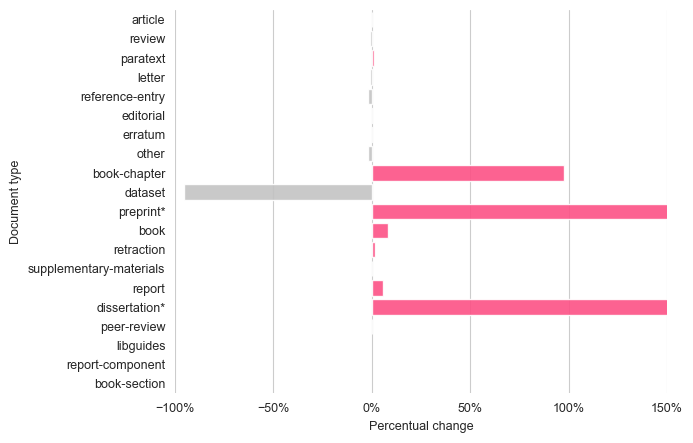

In [90]:
fig, ax = plt.subplots(figsize=(7,4.5))
plt.box(False)

sns.barplot(data=types_plot, 
            x='pct_change', 
            y='type', 
            orient='h',
            saturation=1,
            palette=change_color,
            hue='type',
            alpha=0.9,
            zorder=3,
            errorbar=None,)

ax.xaxis.set_major_formatter(mtick.PercentFormatter(100))

ax.set_xlim(-100, 150)
ax.set(xlabel='Percentual change', ylabel='Document type')

plt.tight_layout()

plt.show()
fig.savefig('media/blog_post_document_types_pct_changes.png', format='png', bbox_inches='tight', dpi=500)

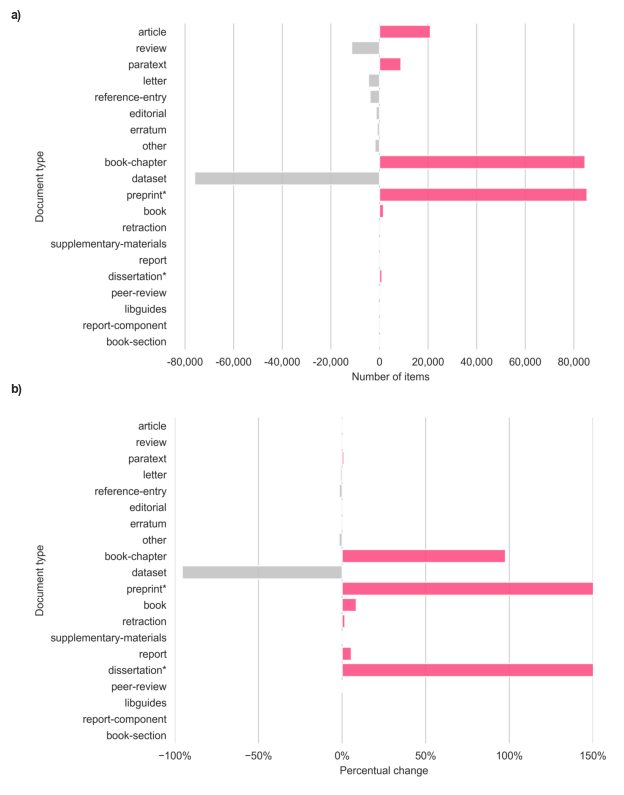

In [111]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
filelist =  ['blog_post_document_types_changes', 'blog_post_document_types_pct_changes']
for i, (ax, file) in enumerate(zip(axs.flat, filelist)):
    ax.set_axis_off()
    filename = 'media/' + file + '.png'
    ax.imshow(mpimg.imread(filename), extent=None)
plt.subplots_adjust(wspace=0, hspace=0.05)
plt.text(-100, -2300, 'a)', size=9, weight='bold')
plt.text(-100, -100, 'b)', size=9, weight='bold')
plt.show()
fig.savefig('media/blog_post_figure1.png', format='png', bbox_inches='tight', dpi=500)

In [84]:
oal_by_source_types = client.query(f"""
                                    SELECT COUNT(DISTINCT(doi)) AS n, primary_location.source.type AS source_type
                                    FROM `subugoe-collaborative.openalex.works`
                                    WHERE publication_year BETWEEN 2018 AND 2024
                                    GROUP BY source_type
                                    ORDER BY n DESC
                                    """).to_dataframe()

In [85]:
walden_by_source_types = client.query(f"""
                                    SELECT COUNT(DISTINCT(doi)) AS n, primary_location.source.type AS source_type
                                    FROM {walden_snapshot}
                                    WHERE publication_year BETWEEN 2018 AND 2024
                                    GROUP BY source_type
                                    ORDER BY n DESC
                                    """).to_dataframe()

In [86]:
source_type_plot = calculate_changes(oal_by_source_types, walden_by_source_types, on='source_type')

In [87]:
source_type_plot['n_openalex_total'] = source_type_plot['n_openalex'].sum()
source_type_plot['openalex_share'] = source_type_plot['n_openalex'] / source_type_plot['n_openalex_total'] * 100

source_type_plot['n_walden_total'] = source_type_plot['n_walden'].sum()
source_type_plot['walden_share'] = source_type_plot['n_walden'] / source_type_plot['n_walden_total'] * 100

In [88]:
source_type_plot

,source_type,n_openalex,n_walden,change,pct_change,n_openalex_total,openalex_share,n_walden_total,walden_share
0,journal,37162915,37265545,102630,0.276162,60488557,61.437926,106943388,34.846049
1,repository,7095230,43716031,36620801,516.132684,60488557,11.729871,106943388,40.877731
2,None,6908023,13455640,6547617,94.782791,60488557,11.42038,106943388,12.582021
3,ebook platform,6502127,3930549,-2571578,-39.549797,60488557,10.74935,106943388,3.675355
4,book series,1488834,1478195,-10639,-0.714586,60488557,2.461348,106943388,1.382222
5,conference,1331331,768789,-562542,-42.254105,60488557,2.200963,106943388,0.718875
6,other,97,187,90,92.783505,60488557,0.00016,106943388,0.000175
7,igsnCatalog,0,6328178,6328178,inf,60488557,0.0,106943388,5.917316
8,metadata,0,270,270,inf,60488557,0.0,106943388,0.000252
9,raidRegistry,0,4,4,inf,60488557,0.0,106943388,0.000004


In [92]:
print(calculate_changes(oal_by_source_types, walden_by_source_types, on='source_type').to_markdown())

|    | source_type    |   n_openalex |   n_walden |   change |   pct_change |
|---:|:---------------|-------------:|-----------:|---------:|-------------:|
|  0 | journal        |     37162915 |   37265545 |   102630 |     0.276162 |
|  1 | repository     |      7095230 |   43716031 | 36620801 |   516.133    |
|  2 |                |      6908023 |   13455640 |  6547617 |    94.7828   |
|  3 | ebook platform |      6502127 |    3930549 | -2571578 |   -39.5498   |
|  4 | book series    |      1488834 |    1478195 |   -10639 |    -0.714586 |
|  5 | conference     |      1331331 |     768789 |  -562542 |   -42.2541   |
|  6 | other          |           97 |        187 |       90 |    92.7835   |
|  7 | igsnCatalog    |            0 |    6328178 |  6328178 |   inf        |
|  8 | metadata       |            0 |        270 |      270 |   inf        |
|  9 | raidRegistry   |            0 |          4 |        4 |   inf        |


In [95]:
print(source_type_plot[['source_type', 'n_openalex', 'n_walden', 'change', 'pct_change', 'openalex_share', 'walden_share']].to_markdown())

|    | source_type    |   n_openalex |   n_walden |   change |   pct_change |   openalex_share |   walden_share |
|---:|:---------------|-------------:|-----------:|---------:|-------------:|-----------------:|---------------:|
|  0 | journal        |     37162915 |   37265545 |   102630 |     0.276162 |     61.4379      |   34.846       |
|  1 | repository     |      7095230 |   43716031 | 36620801 |   516.133    |     11.7299      |   40.8777      |
|  2 |                |      6908023 |   13455640 |  6547617 |    94.7828   |     11.4204      |   12.582       |
|  3 | ebook platform |      6502127 |    3930549 | -2571578 |   -39.5498   |     10.7494      |    3.67535     |
|  4 | book series    |      1488834 |    1478195 |   -10639 |    -0.714586 |      2.46135     |    1.38222     |
|  5 | conference     |      1331331 |     768789 |  -562542 |   -42.2541   |      2.20096     |    0.718875    |
|  6 | other          |           97 |        187 |       90 |    92.7835   |      0.000

In [96]:
oal_by_oa = client.query(f"""
                          SELECT COUNT(DISTINCT(doi)) AS n, open_access.oa_status, publication_year
                          FROM {openalex_snapshot}
                          WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2018 AND 2024 AND (type = 'article' OR type = 'review')
                          GROUP BY oa_status, publication_year
                          ORDER BY n DESC
                          """).to_dataframe()

In [97]:
walden_by_oa = client.query(f"""
                             SELECT COUNT(DISTINCT(doi)) AS n, open_access.oa_status, publication_year
                             FROM {walden_snapshot}
                             WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2018 AND 2024 AND (type = 'article' OR type = 'review')
                             GROUP BY oa_status, publication_year
                             ORDER BY n DESC
                             """).to_dataframe()

In [99]:
calculate_changes(oal_by_oa.groupby(['oa_status'])['n'].sum().reset_index(), walden_by_oa.groupby(['oa_status'])['n'].sum().reset_index(), on='oa_status')

,oa_status,n_openalex,n_walden,change,pct_change
0,bronze,3543148,2885111,-658037,-18.5721
1,closed,14565362,13328327,-1237035,-8.492992
2,diamond,2534510,8849415,6314905,249.156839
3,gold,9204670,5387616,-3817054,-41.468668
4,green,1635056,1435499,-199557,-12.204903
5,hybrid,3401545,3008268,-393277,-11.561717


In [100]:
print(calculate_changes(oal_by_oa.groupby(['oa_status'])['n'].sum().reset_index(), walden_by_oa.groupby(['oa_status'])['n'].sum().reset_index(), on='oa_status').to_markdown())

|    | oa_status   |   n_openalex |   n_walden |   change |   pct_change |
|---:|:------------|-------------:|-----------:|---------:|-------------:|
|  0 | bronze      |      3543148 |    2885111 |  -658037 |    -18.5721  |
|  1 | closed      |     14565362 |   13328327 | -1237035 |     -8.49299 |
|  2 | diamond     |      2534510 |    8849415 |  6314905 |    249.157   |
|  3 | gold        |      9204670 |    5387616 | -3817054 |    -41.4687  |
|  4 | green       |      1635056 |    1435499 |  -199557 |    -12.2049  |
|  5 | hybrid      |      3401545 |    3008268 |  -393277 |    -11.5617  |


In [8]:
oa_plot = pd.merge(oal_by_oa, walden_by_oa, on=['oa_status', 'publication_year'], how='inner', suffixes=('_openalex', '_walden'))

In [9]:
oa_plot = oa_plot.sort_values(by=['oa_status', 'publication_year'])

In [10]:
oa_plot

,n_openalex,oa_status,publication_year,n_walden
20,522654,bronze,2018,393515
22,509085,bronze,2019,389532
21,514737,bronze,2020,401718
19,527598,bronze,2021,395967
18,537456,bronze,2022,355943
17,578841,bronze,2023,489499
29,352777,bronze,2024,458937
5,1922014,closed,2018,1918422
3,1969607,closed,2019,1947236
2,2016341,closed,2020,1963395


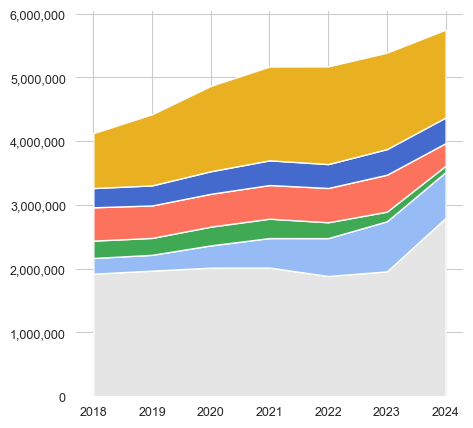

In [13]:
fig, ax = plt.subplots(figsize=(5,5))
plt.box(False)

plt.stackplot([2018, 2019, 2020, 2021, 2022, 2023, 2024], 
              oa_plot[oa_plot.oa_status == 'closed']['n_openalex'].tolist(), 
              oa_plot[oa_plot.oa_status == 'hybrid']['n_openalex'].tolist(), 
              oa_plot[oa_plot.oa_status == 'green']['n_openalex'].tolist(), 
              oa_plot[oa_plot.oa_status == 'bronze']['n_openalex'].tolist(),
              oa_plot[oa_plot.oa_status == 'diamond']['n_openalex'].tolist(), 
              oa_plot[oa_plot.oa_status == 'gold']['n_openalex'].tolist(),
              colors=['#e5e5e5', '#97bbf5ff', '#40a954', '#fd725d', '#446ace', '#e9b121'],
             )

ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.xticks([2018, 2019, 2020, 2021, 2022, 2023, 2024])

plt.show()
fig.savefig('media/blog_post_oa_oal_area_chart.png', format='png', bbox_inches='tight', dpi=500)

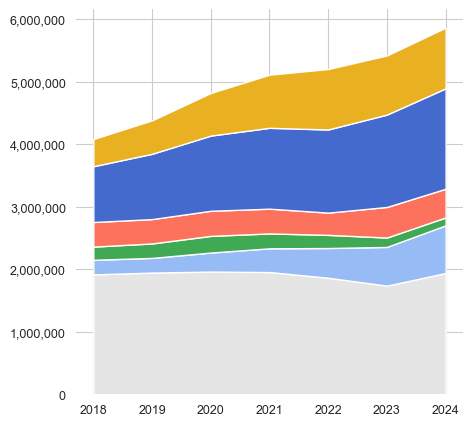

In [14]:
fig, ax = plt.subplots(figsize=(5,5))
plt.box(False)

plt.stackplot([2018, 2019, 2020, 2021, 2022, 2023, 2024], 
              oa_plot[oa_plot.oa_status == 'closed']['n_walden'].tolist(), 
              oa_plot[oa_plot.oa_status == 'hybrid']['n_walden'].tolist(), 
              oa_plot[oa_plot.oa_status == 'green']['n_walden'].tolist(), 
              oa_plot[oa_plot.oa_status == 'bronze']['n_walden'].tolist(),
              oa_plot[oa_plot.oa_status == 'diamond']['n_walden'].tolist(), 
              oa_plot[oa_plot.oa_status == 'gold']['n_walden'].tolist(),
              colors=['#e5e5e5', '#97bbf5ff', '#40a954', '#fd725d', '#446ace', '#e9b121'],
             )

ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.xticks([2018, 2019, 2020, 2021, 2022, 2023, 2024])

plt.show()
fig.savefig('media/blog_post_oa_walden_area_chart.png', format='png', bbox_inches='tight', dpi=500)

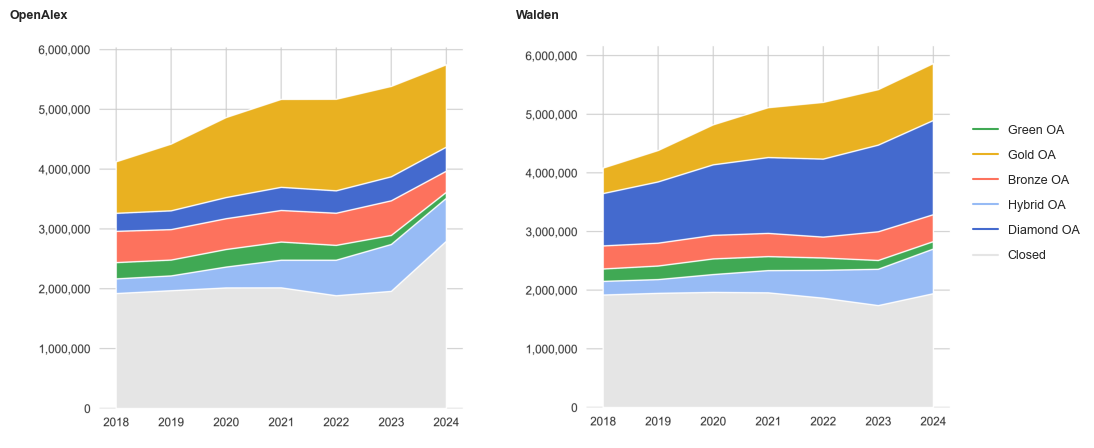

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
filelist =  ['blog_post_oa_oal_area_chart', 'blog_post_oa_walden_area_chart']
for i, (ax, file) in enumerate(zip(axs.flat, filelist)):
    ax.set_axis_off()
    filename = 'media/' + file + '.png'
    ax.imshow(mpimg.imread(filename), extent=None)
plt.subplots_adjust(wspace=0.1, hspace=0)
plt.text(-2700, -100, 'OpenAlex', size=9, weight='bold')
plt.text(0, -100, 'Walden', size=9, weight='bold')

green_oa_patch = Line2D([0], [0], color='#40a954', label='Green OA')
gold_oa_patch = Line2D([0], [0], color='#e9b121', label='Gold OA')
bronze_oa_patch = Line2D([0], [0], color='#fd725d', label='Bronze OA')
hybrid_oa_patch = Line2D([0], [0], color='#97bbf5ff', label='Hybrid OA')
diamond_oa_patch = Line2D([0], [0], color='#446ace', label='Diamond OA')
closed_oa_patch = Line2D([0], [0], color='#e5e5e5', label='Closed')

lgd = fig.legend(handles=[green_oa_patch, 
                          gold_oa_patch, 
                          bronze_oa_patch,
                          hybrid_oa_patch,
                          diamond_oa_patch,
                          closed_oa_patch], frameon=False,
                 bbox_to_anchor=(1.01, 0.65), labelspacing=1.05)


plt.show()
fig.savefig('media/blog_post_figure3.png', format='png', bbox_inches='tight', dpi=500)

In [14]:
oal_by_host = client.query(f"""
                            SELECT COUNT(DISTINCT(doi)) AS n, primary_location.source.host_organization_name
                            FROM {openalex_snapshot}
                            WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2018 AND 2024 AND (type = 'article' OR type = 'review')
                            GROUP BY host_organization_name
                            ORDER BY n DESC
                            """).to_dataframe()

In [15]:
walden_by_host = client.query(f"""
                             SELECT COUNT(DISTINCT(doi)) AS n, primary_location.source.host_organization_name
                             FROM {walden_snapshot}
                             WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2018 AND 2024 AND (type = 'article' OR type = 'review')
                             GROUP BY host_organization_name
                             ORDER BY n DESC
                             """).to_dataframe()

In [16]:
host_plot = calculate_changes(oal_by_host, walden_by_host, on='host_organization_name').sort_values(by=['n_openalex'], ascending=False)

In [17]:
oal_by_host_references = client.query(f"""
                                      SELECT SUM(referenced_works_count) AS n, primary_location.source.host_organization_name
                                      FROM {openalex_snapshot}
                                      WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2018 AND 2024 AND (type = 'article' OR type = 'review')
                                      GROUP BY host_organization_name
                                      ORDER BY n DESC
                                      """).to_dataframe()

In [18]:
walden_by_host_references = client.query(f"""
                                          SELECT SUM(referenced_works_count) AS n, primary_location.source.host_organization_name
                                          FROM {walden_snapshot}
                                          WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2018 AND 2024 AND (type = 'article' OR type = 'review')
                                          GROUP BY host_organization_name
                                          ORDER BY n DESC
                                          """).to_dataframe()

In [19]:
ref_plot = calculate_changes(oal_by_host_references, walden_by_host_references, on='host_organization_name').sort_values(by=['n_openalex'], ascending=False)

In [20]:
host_plot_merge = pd.merge(host_plot, ref_plot, on=['host_organization_name'], how='outer', suffixes=('_items', '_refs'))

In [22]:
host_top_20_plot = host_plot_merge.sort_values(by=['n_openalex_items'], ascending=False).head(21)

In [23]:
#host_top_20_plot.replace(to_replace=[None], value='None', inplace=True)

In [24]:
host_top_20_plot

,host_organization_name,n_openalex_items,n_walden_items,change_items,pct_change_items,n_openalex_refs,n_walden_refs,change_refs,pct_change_refs
0,None,8504822,8658958,154136,1.812337,61376055,69072543,7696488,12.539887
1,Elsevier BV,5310142,5290767,-19375,-0.364868,205490953,221968191,16477238,8.018474
2,Springer Science+Business Media,1725031,1719995,-5036,-0.291937,68335429,69781040,1445611,2.115463
3,Wiley,1704126,1694799,-9327,-0.547319,68287084,70288508,2001424,2.930897
4,Multidisciplinary Digital Publishing Institute,1380269,1377671,-2598,-0.188224,72602925,77215383,4612458,6.352992
5,Taylor & Francis,884007,878085,-5922,-0.669904,31776175,32544861,768686,2.419064
6,Oxford University Press,585923,583037,-2886,-0.492556,15676432,16797118,1120686,7.148859
7,SAGE Publishing,532495,530335,-2160,-0.405638,16620534,16874504,253970,1.52805
8,Lippincott Williams & Wilkins,512114,514345,2231,0.435645,7607006,8436201,829195,10.900412
9,Institute of Electrical and Electronics Engineers,460108,454684,-5424,-1.178854,14419607,16624890,2205283,15.293641


In [25]:
print(host_top_20_plot.to_markdown())

|    | host_organization_name                            |   n_openalex_items |   n_walden_items |   change_items |   pct_change_items |   n_openalex_refs |   n_walden_refs |   change_refs |   pct_change_refs |
|---:|:--------------------------------------------------|-------------------:|-----------------:|---------------:|-------------------:|------------------:|----------------:|--------------:|------------------:|
|  0 |                                                   |            8504822 |          8658958 |         154136 |          1.81234   |          61376055 |        69072543 |       7696488 |         12.5399   |
|  1 | Elsevier BV                                       |            5310142 |          5290767 |         -19375 |         -0.364868  |         205490953 |       221968191 |      16477238 |          8.01847  |
|  2 | Springer Science+Business Media                   |            1725031 |          1719995 |          -5036 |         -0.291937  |          68335429 |

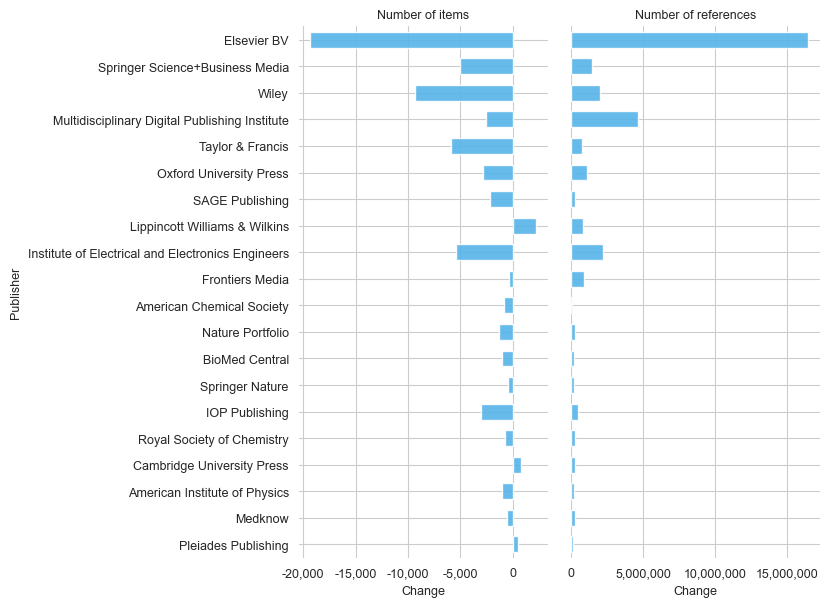

In [35]:
g = sns.PairGrid(host_top_20_plot,
                 x_vars=['change_items', 'change_refs'], 
                 y_vars=['host_organization_name'], 
                 height=6, 
                 aspect=.5)

g.map(sns.barplot,
      color='#56B4E9',
      width=0.6,
      saturation=1,
      alpha=0.9,
      zorder=3,
      errorbar=None,
      orient='y')

plt.box(False)

g.set(xlabel='Change', ylabel='Publisher')

titles = ['Number of items', 'Number of references']

for ax, title in zip(g.axes.flat, titles):

    ax.set(title=title)

    ax.xaxis.grid(True)
    ax.yaxis.grid(True)

    #ax.xaxis.set_major_formatter(mtick.PercentFormatter())
    
    #ax.set_xticklabels([f'{x:.0f}%' for x in ax.get_xticks()]) 

    ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

sns.despine(left=True, bottom=True)

fig = g.fig.get_figure()

plt.show()
fig.savefig('media/blog_post_figure4.png', format='png', bbox_inches='tight', dpi=500)

In [80]:
oal_by_pubyear = client.query(f"""
                               SELECT COUNT(DISTINCT(doi)) AS n, publication_year
                               FROM `subugoe-collaborative.openalex.works`
                               WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2018 AND 2024 AND (type = 'article' OR type = 'review')
                               GROUP BY publication_year
                               ORDER BY publication_year DESC
                               """).to_dataframe()

In [81]:
walden_by_pubyear = client.query(f"""
                                  SELECT COUNT(DISTINCT(doi)) AS n, publication_year
                                  FROM {walden_snapshot}
                                  WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2018 AND 2024 AND (type = 'article' OR type = 'review')
                                  GROUP BY publication_year
                                  ORDER BY publication_year DESC
                                  """).to_dataframe()

In [82]:
calculate_changes(oal_by_pubyear, walden_by_pubyear, on='publication_year').sort_values(by=['change'], ascending=False)

,publication_year,n_openalex,n_walden,change,pct_change
0,2024,5747463,5866769,119306,2.075803
1,2023,5385802,5421376,35574,0.660514
2,2022,5170934,5204308,33374,0.645415
5,2019,4421064,4383193,-37871,-0.856604
6,2018,4124893,4083617,-41276,-1.000656
4,2020,4865503,4820914,-44589,-0.916431
3,2021,5168607,5113724,-54883,-1.061853


In [83]:
print(calculate_changes(oal_by_pubyear, walden_by_pubyear, on='publication_year').to_markdown())

|    |   publication_year |   n_openalex |   n_walden |   change |   pct_change |
|---:|-------------------:|-------------:|-----------:|---------:|-------------:|
|  0 |               2024 |      5747463 |    5866769 |   119306 |     2.0758   |
|  1 |               2023 |      5385802 |    5421376 |    35574 |     0.660514 |
|  2 |               2022 |      5170934 |    5204308 |    33374 |     0.645415 |
|  3 |               2021 |      5168607 |    5113724 |   -54883 |    -1.06185  |
|  4 |               2020 |      4865503 |    4820914 |   -44589 |    -0.916431 |
|  5 |               2019 |      4421064 |    4383193 |   -37871 |    -0.856604 |
|  6 |               2018 |      4124893 |    4083617 |   -41276 |    -1.00066  |


In [57]:
oal_by_pubyear['dataset'] = 'OpenAlex'
walden_by_pubyear['dataset'] = 'Walden'

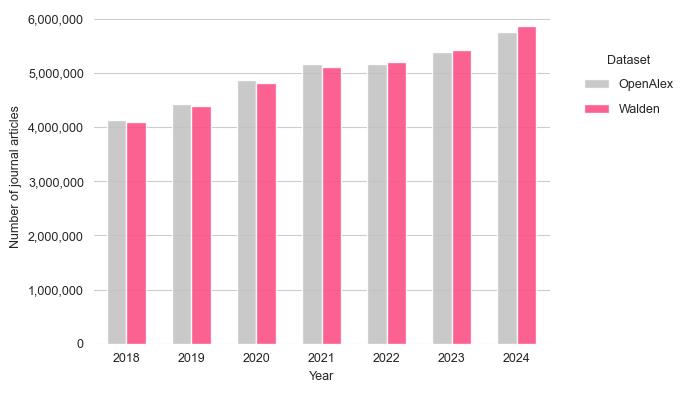

In [61]:
fig, ax = plt.subplots(figsize=(7,4))
plt.box(False)

sns.barplot(data=pd.concat([oal_by_pubyear, walden_by_pubyear], ignore_index=True),
             x='publication_year',
             y='n',
             palette=['#c3c3c3', '#fc5185'],
             hue='dataset',
             width=0.6,
             saturation=1,
             alpha=0.9,
             zorder=3,
             errorbar=None,
             ax=ax)

ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

ax.grid(False, which='both', axis='x')

ax.set(xlabel='Year', ylabel='Number of journal articles')

ax.legend(bbox_to_anchor=(1.05, 0.9),
          frameon=False,
          title='Dataset',
          labelspacing=1.0)

plt.tight_layout()

plt.show()
fig.savefig('media/blog_post_pubyear.png', format='png', bbox_inches='tight', dpi=500)

In [32]:
oal_grants = client.query(f"""
                           SELECT COUNT(grant.award_id) AS n, publication_year
                           FROM `subugoe-collaborative.openalex.works`, UNNEST(grants) AS grant
                           WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2018 AND 2024 AND (type = 'article' OR type = 'review')
                           GROUP BY publication_year
                           ORDER BY n DESC
                           """).to_dataframe()

In [33]:
walden_grants = client.query(f"""
                               SELECT COUNT(grant.id) AS n, publication_year
                               FROM {walden_snapshot}, UNNEST(awards) AS grant
                               WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2018 AND 2024 AND (type = 'article' OR type = 'review')
                               GROUP BY publication_year
                               ORDER BY n DESC
                               """).to_dataframe()

In [34]:
calculate_changes(oal_grants, walden_grants, on='publication_year')

,publication_year,n_openalex,n_walden,change,pct_change
0,2024,1829832,1878897,49065,2.681394
1,2023,1798571,1860801,62230,3.459969
2,2022,1792249,1835203,42954,2.396654
3,2021,1757777,1783645,25868,1.471631
4,2020,1707755,1758263,50508,2.957567
5,2019,1574415,1628985,54570,3.466049
6,2018,1363660,1419688,56028,4.108649


In [37]:
calculate_changes(oal_grants, walden_grants, on='publication_year').n_openalex.sum()

11824259

In [38]:
calculate_changes(oal_grants, walden_grants, on='publication_year').n_walden.sum()

12165482

In [36]:
print(calculate_changes(oal_grants, walden_grants, on='publication_year').to_markdown())

|    |   publication_year |   n_openalex |   n_walden |   change |   pct_change |
|---:|-------------------:|-------------:|-----------:|---------:|-------------:|
|  0 |               2024 |      1829832 |    1878897 |    49065 |      2.68139 |
|  1 |               2023 |      1798571 |    1860801 |    62230 |      3.45997 |
|  2 |               2022 |      1792249 |    1835203 |    42954 |      2.39665 |
|  3 |               2021 |      1757777 |    1783645 |    25868 |      1.47163 |
|  4 |               2020 |      1707755 |    1758263 |    50508 |      2.95757 |
|  5 |               2019 |      1574415 |    1628985 |    54570 |      3.46605 |
|  6 |               2018 |      1363660 |    1419688 |    56028 |      4.10865 |


In [19]:
oal_grants['dataset'] = 'OpenAlex'
walden_grants['dataset'] = 'Walden'

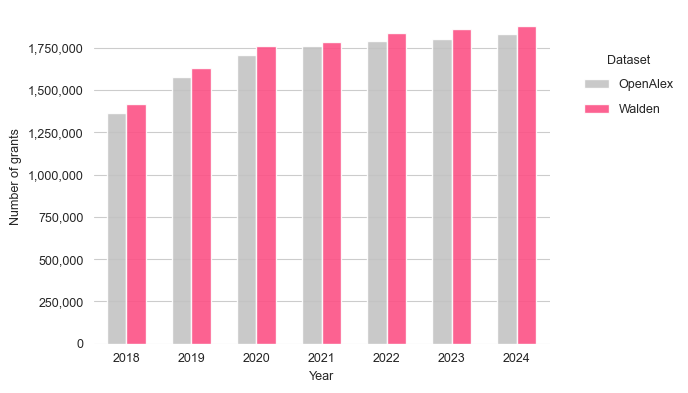

In [23]:
fig, ax = plt.subplots(figsize=(7,4))
plt.box(False)

sns.barplot(data=pd.concat([oal_grants, walden_grants], ignore_index=True),
             x='publication_year',
             y='n',
             palette=['#c3c3c3', '#fc5185'],
             hue='dataset',
             width=0.6,
             saturation=1,
             alpha=0.9,
             zorder=3,
             errorbar=None,
             ax=ax)


ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

ax.set(xlabel='Year', ylabel='Number of grants')

ax.legend(bbox_to_anchor=(1.05, 0.9),
          frameon=False,
          title='Dataset',
          labelspacing=1.0)

plt.tight_layout()

plt.show()
fig.savefig('media/blog_post_grants.png', format='png', bbox_inches='tight', dpi=500)